# Planejamento da solução

1. Exploração dos dados visando encontrar inconsistências, tratamento de dados faltantes e possíveis insights que possam ser úteis ao time de negócios

2. Levantar hipóteses a partir da análise feita e validar as hipóteses em busca da correlações que possam ser úteis para o modelo de machine learning.

3. Preparação dos dados utlizando técnicas de rescaling e encodings.

4. Teste de vários algoritmos classificadores.

5. Avaliação dos modelos e tunning dos parametros.

6. Contabilizar a performance do modelo de Machine Learning e transformar em performance de negócio.

7. Fazer relatório respondedo as perguntas de negócio

8. Colocar modelo em produção e acessar as predições via Google Sheets

# 0.0 Imports

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import scikitplot as sckp
from IPython.core.display    import display, HTML
from pandas_profiling import ProfileReport

## 0.1 Helper Functions

In [131]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    warnings.filterwarnings('ignore')
    sns.set()
    
jupyter_settings()

def ml_metrics(model_name, y_true, pred):
    
    accuracy = m.balanced_accuracy_score(y_true, pred)
    precision = m.precision_score(y_true, pred)
    recall = m.recall_score(y_true, pred)
    f1 = m.f1_score(y_true, pred)
    kappa = m.cohen_kappa_score(y_true, pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 2), 
                         'Precision': np.round(precision, 2), 
                         'Recall': np.round(recall, 2),
                         'F1': np.round(f1, 2),
                         'Kappa': np.round(kappa, 2)}, index=[model_name])


def metrics_at_k(data, model_name, k=20000):
        
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    # precision
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    # recall
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
                            
    return pd.DataFrame({'Precision_at_k':data.loc[k, 'precision_at_k'],
                        'Recall_at_k':data.loc[k, 'recall_at_k']}, index=[model_name])

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [132]:
df_raw = pd.read_csv('../data/insurance_cross_sell.csv')
df_raw_test = pd.read_csv('../data/test.csv')

# 1.0 Data Description

In [133]:
df1 = df_raw.copy()

 - **Id**: identificador único do cliente.
 
 - **Gender**: gênero do cliente.
 - **Age**: idade do cliente.
 - **Driving License**: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
 - **Region Code**: código da região do cliente.
 - **Previously Insured**: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
 - **Vehicle Age**: idade do veículo.
 - **Vehicle Damage**: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
 - **Anual Premium**: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
 - **Policy sales channel**: código anônimo para o canal de contato com o cliente.
 - **Vintage**: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
 - **Response**: 0, o cliente não tem interesse e 1, o cliente tem interesse.

## 1.1 Droping repeated columns

In [134]:
df1 = df1.drop(columns=['id.1', 'id.2'], axis=1)

In [135]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.000,152.000,1,< 1 Year,Yes,0,23367.000,249,0
1,13,Female,41,15.000,14.000,1,1-2 Year,No,1,31409.000,221,0
2,18,Female,25,35.000,152.000,1,< 1 Year,No,1,46622.000,299,0
3,31,Female,26,8.000,160.000,1,< 1 Year,No,0,2630.000,136,0
4,39,Male,45,8.000,124.000,1,1-2 Year,Yes,0,42297.000,264,0


## 1.2 Data Dimensions

In [136]:
df1.shape

(381109, 12)

## 1.3 Data Types

In [137]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [138]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout Na

There are not Nan values in the dataset

## 1.6 Change Types

In [139]:
#changing the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis.
dic = {1:'yes', 0:'no'}

df1['driving_license'] =  df1['driving_license'].map(dic)
df1['previously_insured'] = df1['previously_insured'].map(dic)
df1['response'] = df1['response'].map(dic)
df1['region_code'] = df1['region_code'].astype('int64')

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

In [140]:
# Central tendecy - mean, median
# Dispersion - std, min, max, skew, kurtosis
skew = df1.skew()
kurtosis = df1.kurtosis()

In [141]:
metrics = pd.DataFrame(df1.describe().drop(['count','25%','75%']).T)
metrics = pd.concat([metrics, skew, kurtosis], axis=1)
metrics.columns = ['Mean','STD','Min','Median','Max',' Skew','Kurtosis']
metrics

,Mean,STD,Min,Median,Max,Skew,Kurtosis
id,190555.000,110016.836,1.000,190555.000,381109.000,-0.000,-1.200
age,38.823,15.512,20.000,36.000,85.000,0.673,-0.566
region_code,26.389,13.230,0.000,28.000,52.000,-0.115,-0.868
policy_sales_channel,112.034,54.204,1.000,133.000,163.000,-0.900,-0.971
annual_premium,30564.390,17213.155,2630.000,31669.000,540165.000,1.766,34.005
vintage,154.347,83.671,10.000,154.000,299.000,0.003,-1.201


### 1.7.2 Categorical Attributes

In [142]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                2
driving_license       2
vehicle_age           3
vehicle_damage        2
previously_insured    2
response              2
dtype: int64

In [143]:
cat_attributes.describe()

,gender,driving_license,vehicle_age,vehicle_damage,previously_insured,response
count,381109,381109,381109,381109,381109,381109
unique,2,2,3,2,2,2
top,Male,yes,1-2 Year,Yes,no,no
freq,206089,380297,200316,192413,206481,334399


# 2.0 Feature Engineering

In [144]:
df2 = df1.copy()

## 2.1 Feature Creation

In [145]:
# risk -  risco dos clientes precisarem usar o seguro do carro baseado na idade e se já tiveram algum acidente (carro danificado) 
df2['risk'] = df2[['age','vehicle_damage']].apply(lambda x: 'high_risk' if (x['age'] <= 35) & (x['vehicle_damage'] == 'Yes') else 'medium_risk'
                                                  if ((x['age'] > 35) & (x['vehicle_damage'] == 'Yes') | (x['age'] <= 35) & (x['vehicle_damage'] == 'No')) else 'low_risk', axis=1)

## 2.2 Hypotheses List

1. Mulheres se interessam mais do que homens em um seguro de carro.
2. Clientes com mais de 40 anos possuem mais interesse por um seguro de carro.
3. Clientes com veículos mais novos do que 1 ano tem mais interesse por um seguro de carro.
4. Clientes que há tiveram seu veículo danificado tendem a se interessar por um seguro de carro.
5. Clintes que já possuem seguro de automóvel tendem a não se interessar em um uma nova oferta de seguro.
6. Clientes que gastam mais de 50.000 no seguro de saúde tendem a ter interesse por um seguro de carro.
7. Clientes que estão com o seguro de saúde a mais de 100 dias tendem ter interesse por um seguro de carro.
8. Clientes com veículos com menos de 1 ano e que atualmente não possuem seguro de carro tendem a ter mais interesse em adquirir um seguro. 
9. Clientes com risco alto tendem a ter mais interesse por um seguro de carro.
10. Clientes de diferentes regiões possuem interesses diferentes por um seguro de carro

# 3.0 Variables Filtering

In [146]:
df3 = df2.copy()

In [147]:
df3= df3.drop('id', axis=1)

# 4.0 EDA

In [148]:
df4 = df3.copy()

### Pandas Profiling

In [149]:
#report = ProfileReport(df4, title='Pandas Profiling Report', correlations={ "kendall": {"calculate": False}})

In [150]:
#report.to_file('report.html')

## 4.1 Univariate Analisys

### 4.1.1 Response Variable

<AxesSubplot:xlabel='response', ylabel='count'>

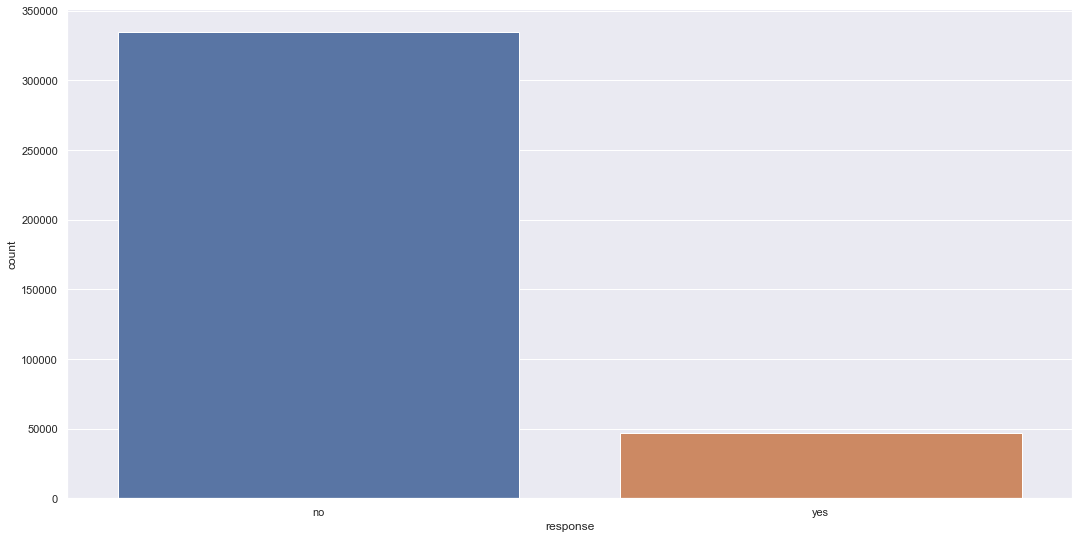

In [151]:
sns.countplot(df4['response'])

### 4.1.2 Numerical Variables

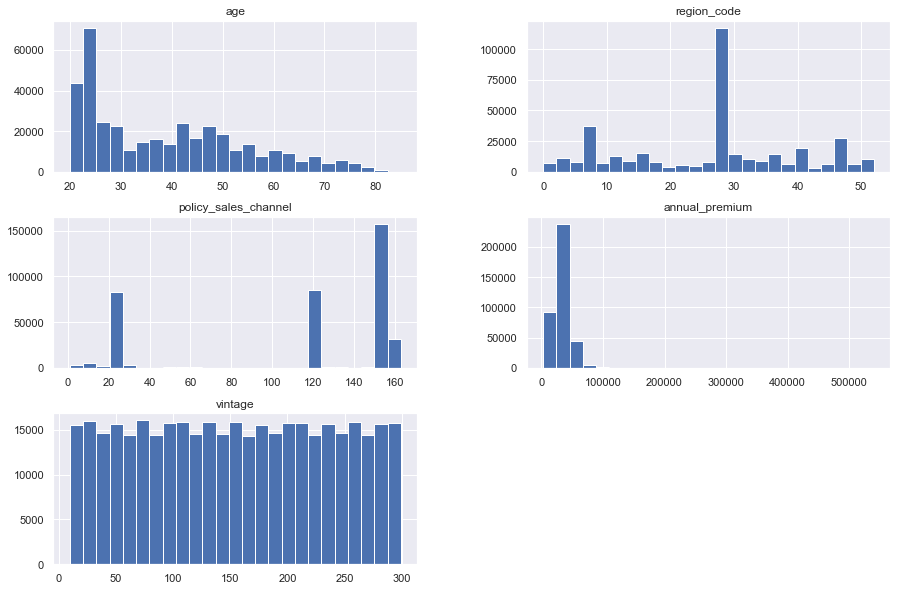

In [152]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist(figsize=(15,10), bins=25);

<AxesSubplot:xlabel='response', ylabel='age'>

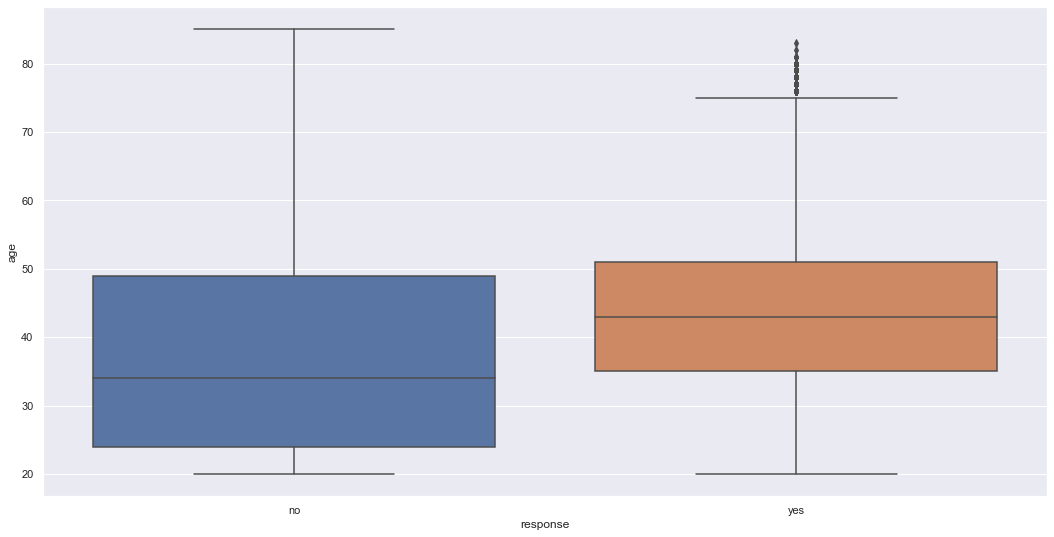

In [153]:
# Age
sns.boxplot(x='response',y='age', data=df4)

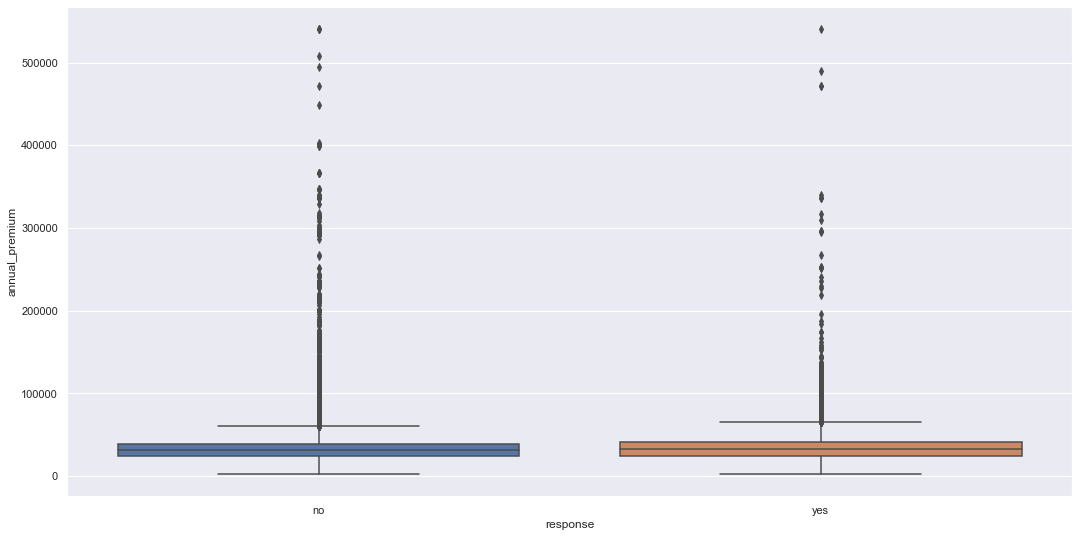

In [154]:
# Annual Premium
sns.boxplot(x='response', y='annual_premium', data=df4);

<AxesSubplot:xlabel='response', ylabel='vintage'>

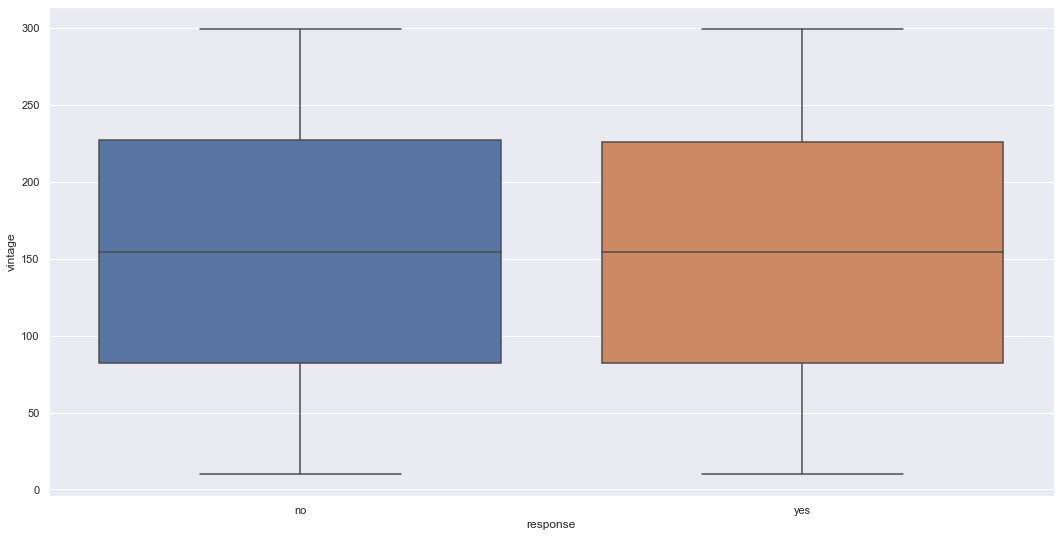

In [155]:
# vintage
sns.boxplot(x='response',y='vintage', data=df4)

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

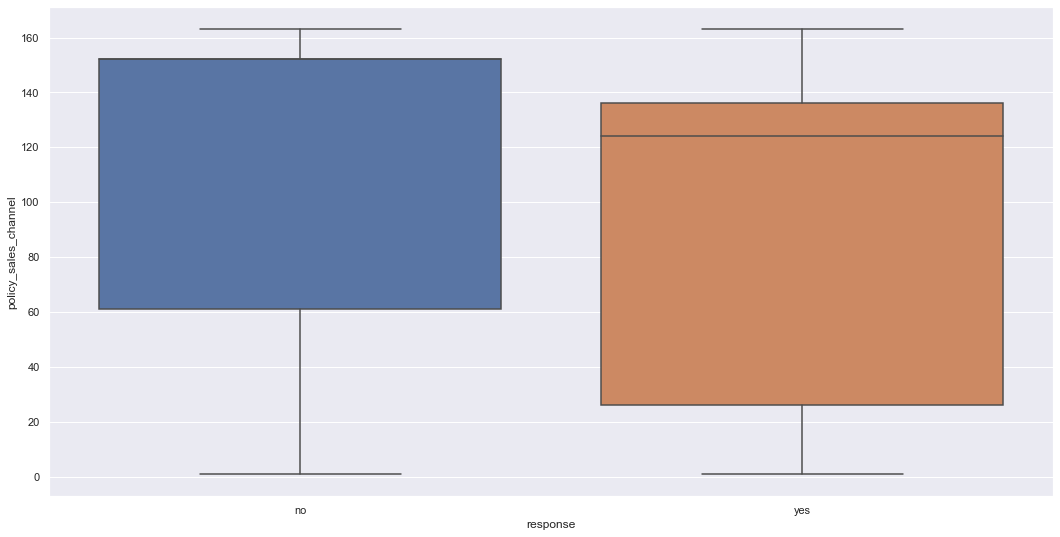

In [156]:
# Policy sales channel
sns.boxplot(x='response', y='policy_sales_channel', data=df4)

### 4.1.3 Categorical Attributes 

In [157]:
cat_attributes = df4.select_dtypes(include='object')

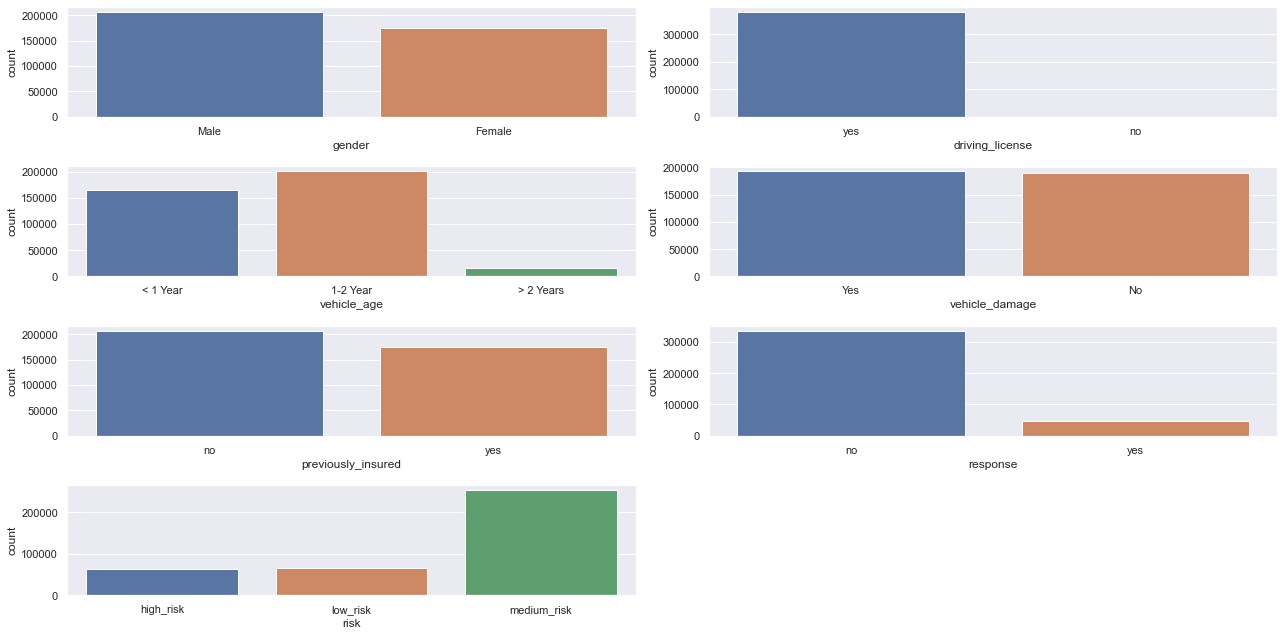

In [158]:
j = 1
for i in cat_attributes:
    plt.subplot(4,2,j)
    sns.countplot(x=i, data=df4)
    plt.tight_layout()
    j +=1

## 4.2 Bivariate Analysis

### H1. Mulheres se interessam mais do que homens em um seguro de carro. 
**Falsa** - Homens se interessam 57% a mais do que mulheres em um seguro de carro

In [159]:
aux1 = df4[['gender','response']].copy()
aux1 = aux1.loc[aux1['response'] == 'yes'].groupby('gender').count().reset_index().sort_values('response', ascending=True)
aux1['diference (%)'] = aux1['response'].pct_change()
aux1

,gender,response,diference (%)
0,Female,18185,NaN
1,Male,28525,0.569


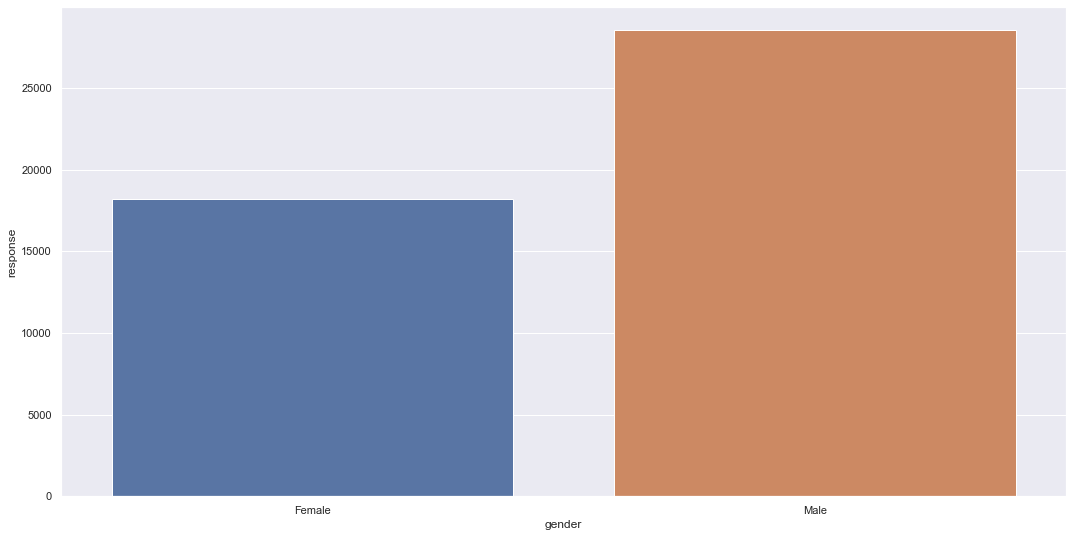

In [160]:
sns.barplot(x='gender', y='response', data=aux1);

### H2. Clientes com mais de 40 anos possuem mais interesse por um seguro de carro.
**Verdadeira** - Clientes com mais de 40 anos possuem mais interesse em um seguro de carro

In [161]:
aux = df4[['age','response']][df4['response'] == 'yes'].copy()
aux['age'] = aux['age'].apply(lambda x: 'more than 40' if x >= 40 else 'less then 40' )
aux1 = aux[['age','response']].groupby('age').count().reset_index()
aux1

,age,response
0,less then 40,17230
1,more than 40,29480


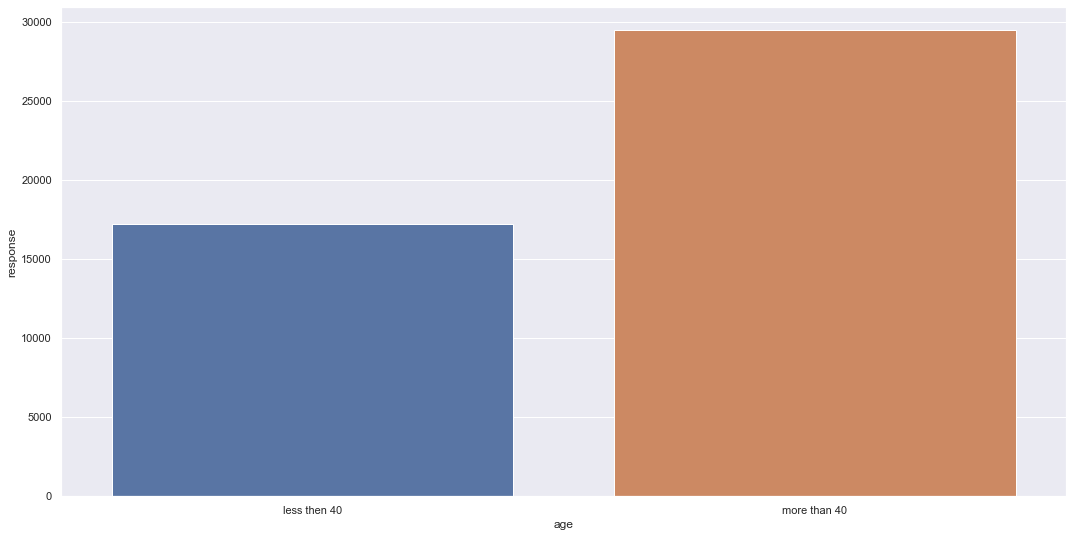

In [162]:
sns.barplot(x='age',y='response', data=aux1);

### H3. Clientes com veículos mais novos do que 1 ano tem mais interesse por um seguro de carro.
**Falsa** - Clientes com veículos com idade entre 1 e 2 anos tem mais interesse por seguro de carro

In [163]:
aux = df4[['vehicle_age','response']][df4['response'] == 'yes'].copy() 
aux = aux.groupby('vehicle_age').count().reset_index()
aux

,vehicle_age,response
0,1-2 Year,34806
1,< 1 Year,7202
2,> 2 Years,4702


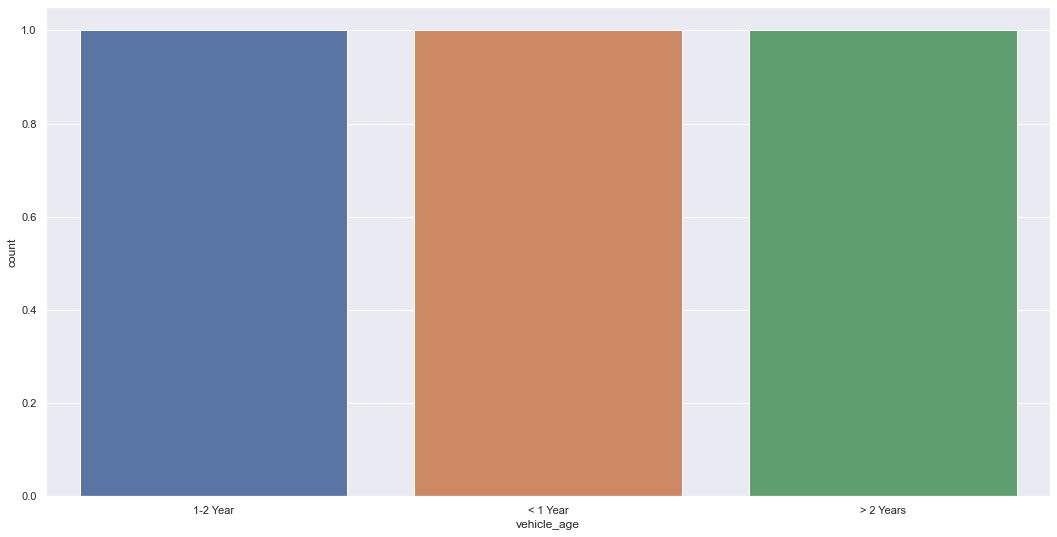

In [164]:
sns.countplot(aux['vehicle_age']);

### H4. Clientes que há tiveram seu veículo danificado tendem a se interessar por um seguro de carro.
**Verdadeira**

In [165]:
aux = df4[['response','vehicle_damage']][df4['response'] == 'yes'].copy()
aux = aux.groupby('vehicle_damage').count().reset_index()
aux

,vehicle_damage,response
0,No,982
1,Yes,45728


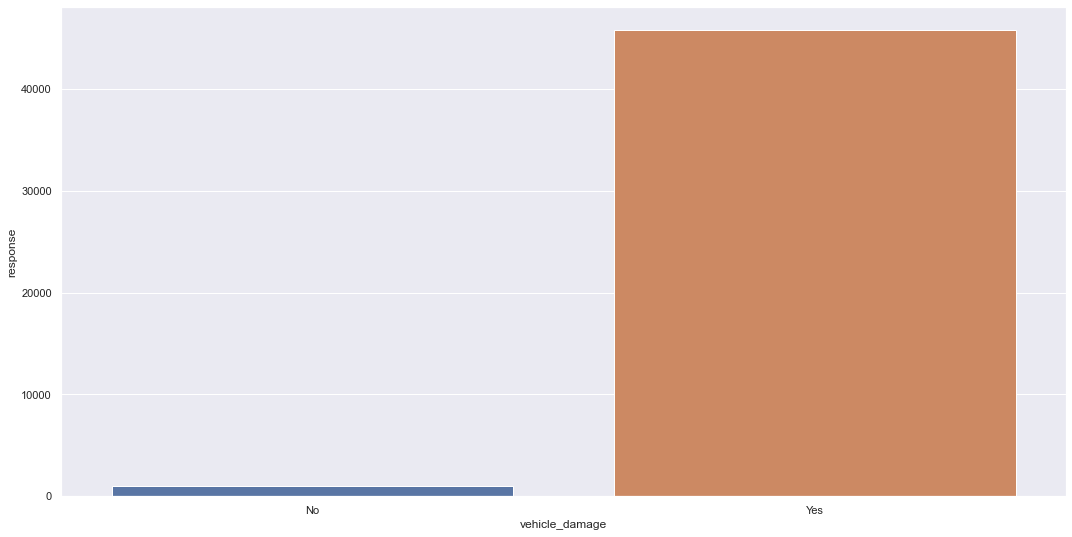

In [166]:
sns.barplot(x='vehicle_damage',y='response', data=aux);

### H5. Clintes que já possuem seguro de automóvel tendem a não se interessar em um uma nova oferta de seguro.
**Verdadeira**

In [167]:
aux = df4[['response','previously_insured']][df4['response'] == 'yes'].copy()
aux = aux.groupby('previously_insured').count().reset_index()
aux

,previously_insured,response
0,no,46552
1,yes,158


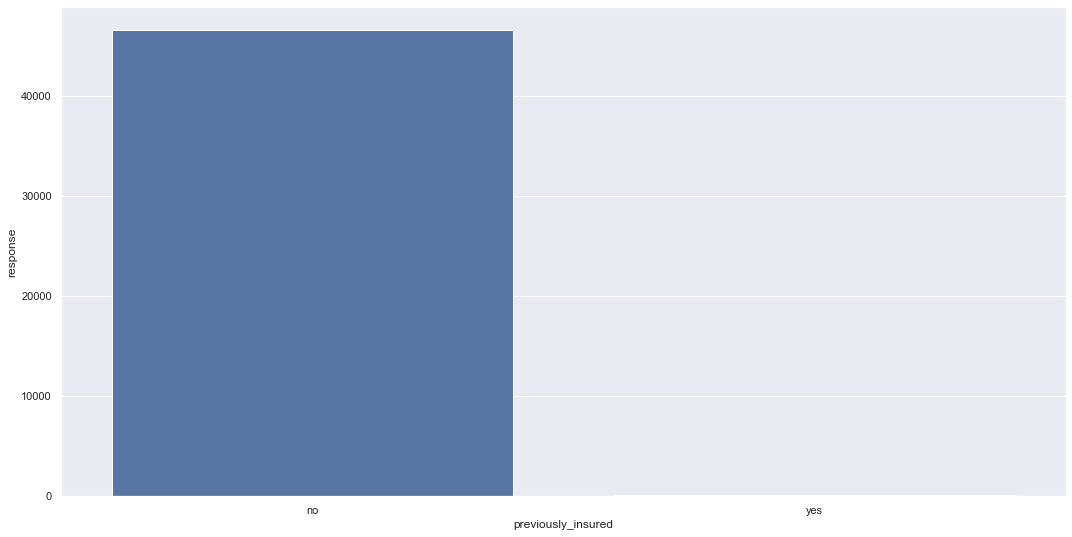

In [168]:
sns.barplot(x='previously_insured', y='response', data=aux);

### H6. Clientes que gastam mais de 50.000 no seguro de saúde tendem a ter interesse por um seguro de carro.
**Falsa** - Clientes que gastam menos de 50.000 no seguro de saúde tendem a ter interesse por um seguro de carro

In [169]:
aux = df4[['annual_premium','response']][df4['response'] == 'yes'].copy()
aux['annual_premium'] = aux['annual_premium'].apply(lambda x: 'more than 50k' if x > 50000 else 'less then 50k')
aux1 = aux[['annual_premium','response']].groupby('annual_premium').count().reset_index()
aux1

,annual_premium,response
0,less then 50k,41811
1,more than 50k,4899


<AxesSubplot:xlabel='annual_premium', ylabel='response'>

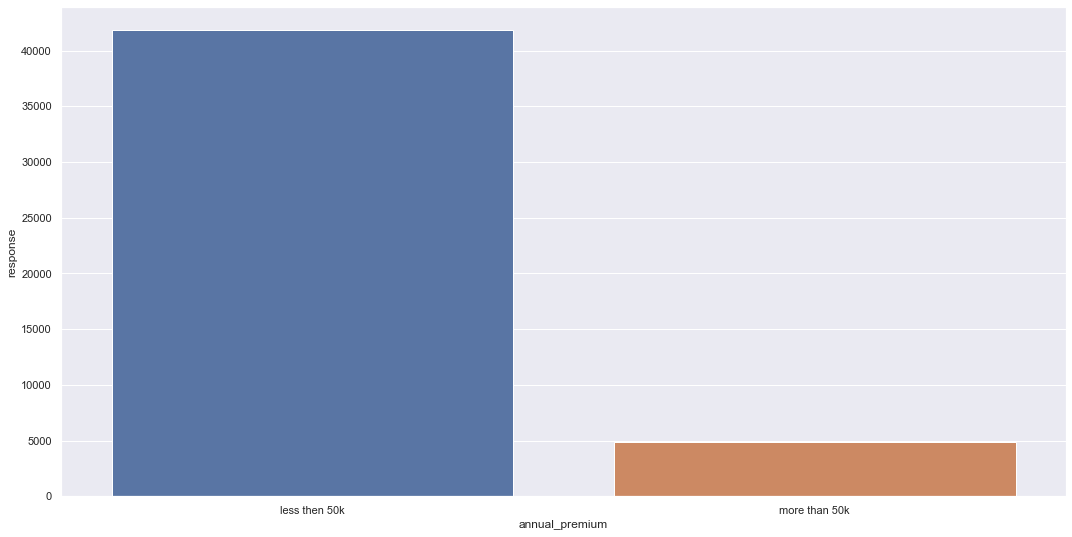

In [170]:
sns.barplot(x='annual_premium', y='response', data=aux1)

### H7. Clientes que estão com o seguro de saúde a mais de 100 dias tendem ter interesse por um seguro de carro.
**Verdadeira**

In [171]:
aux = df4[['vintage','response']][df4['response'] == 'yes'].copy()
aux['vintage'] = aux['vintage'].apply(lambda x: 'more than 100' if x > 100 else 'less then 100')
aux1 = aux[['vintage','response']].groupby('vintage').count().reset_index()
aux1

,vintage,response
0,less then 100,14680
1,more than 100,32030


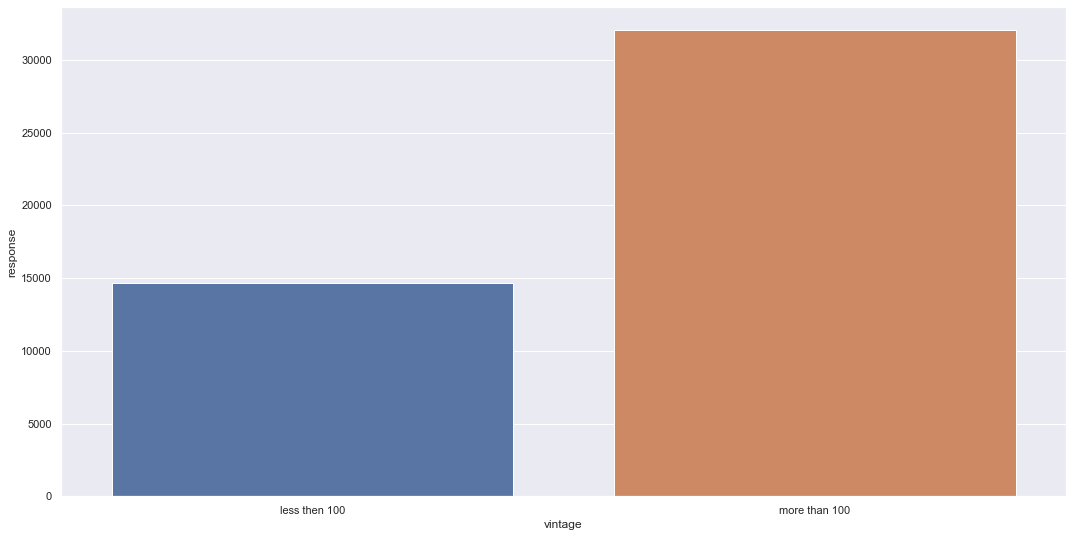

In [172]:
sns.barplot(x='vintage',y='response', data=aux1);

### H8. Clientes com veículos com menos de 1 ano e que atualmente não possuem seguro de carro tendem a ter mais interesse em adquirir um seguro. 
**Falsa** - Clientes com veículos entre 1 e 2 anos e que atualmente não possuem seguro de carro tendem a ter mais interesse em adquirir um seguro.

In [173]:
aux = df4[['vehicle_age','previously_insured','response']][df4['response'] == 'yes'].copy()
aux = aux.groupby(['vehicle_age','previously_insured']).count().reset_index()
aux

,vehicle_age,previously_insured,response
0,1-2 Year,no,34711
1,1-2 Year,yes,95
2,< 1 Year,no,7140
3,< 1 Year,yes,62
4,> 2 Years,no,4701
5,> 2 Years,yes,1


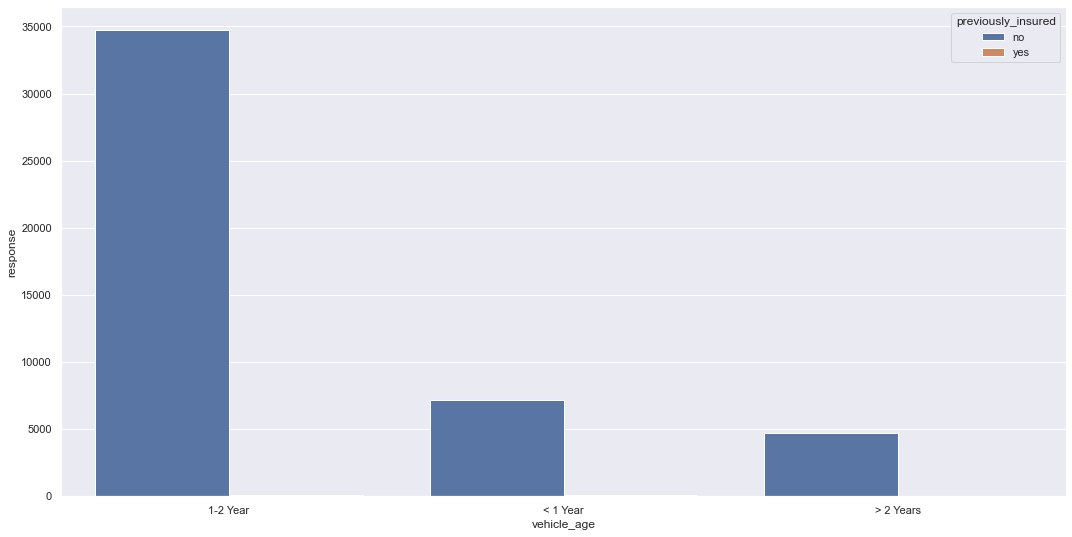

In [174]:
sns.barplot(x='vehicle_age',y='response', hue='previously_insured', data=aux);

### H9.  Clientes com risco alto tendem a ter mais interesse por um seguro de carro.
**Falsa** - Clientes com rusco médio tendem a ter mais interesse por um seguro de carr

In [175]:
aux = df4[['risk','response']][df4['response'] == 'yes'].copy()
aux = aux.groupby('risk').count().reset_index()
aux

,risk,response
0,high_risk,11718
1,low_risk,455
2,medium_risk,34537


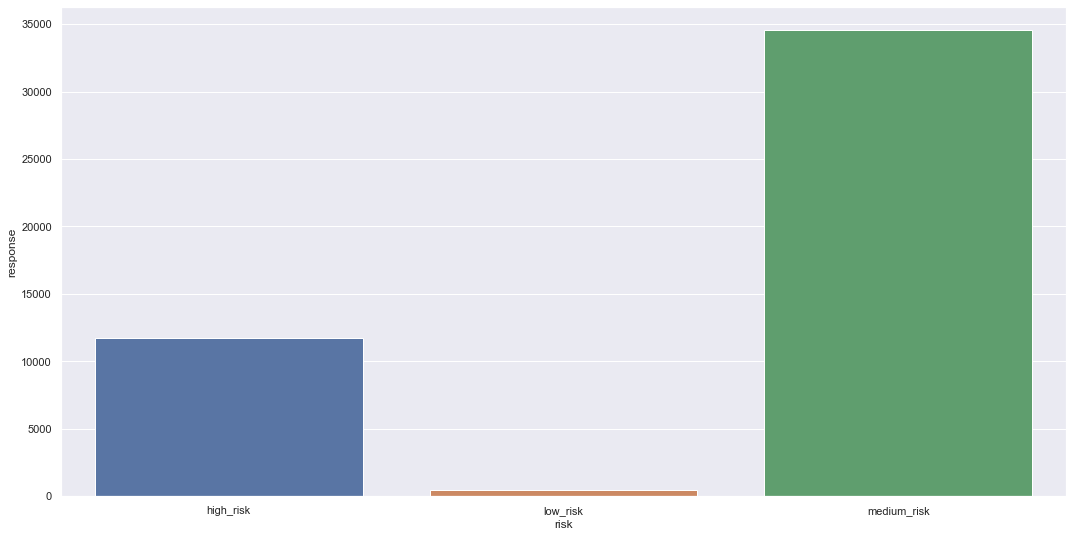

In [176]:
sns.barplot(x='risk',y='response', data=aux);

### H10.  Clientes de diferentes regiões possuem interesses diferentes por um seguro de carro
**Verdadeira**

In [177]:
aux = df4[['region_code','response']][df4['response'] == 'yes'].copy()
aux = aux.groupby('region_code').count().reset_index()

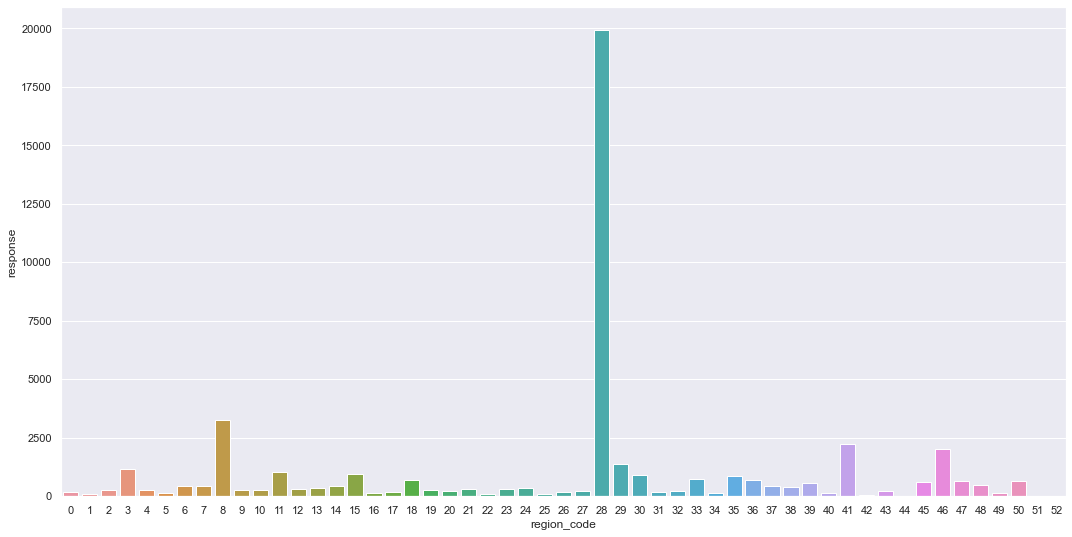

In [178]:
sns.barplot(x='region_code',y='response', data=aux);

## 4.3 Multivariate Analisys

In [44]:
dic = {'yes':1, 'no':0}

df4['driving_license'] =  df4['driving_license'].map(dic)
df4['previously_insured'] = df4['previously_insured'].map(dic)
df4['response'] = df4['response'].map(dic)
df4['vehicle_damage'] = df4['vehicle_damage'].map({'Yes':1,'No':0})

### 4.3.1 Numerical Attribues

In [45]:
num_atributes = df4.select_dtypes(include=['int64','float64'])

<AxesSubplot:>

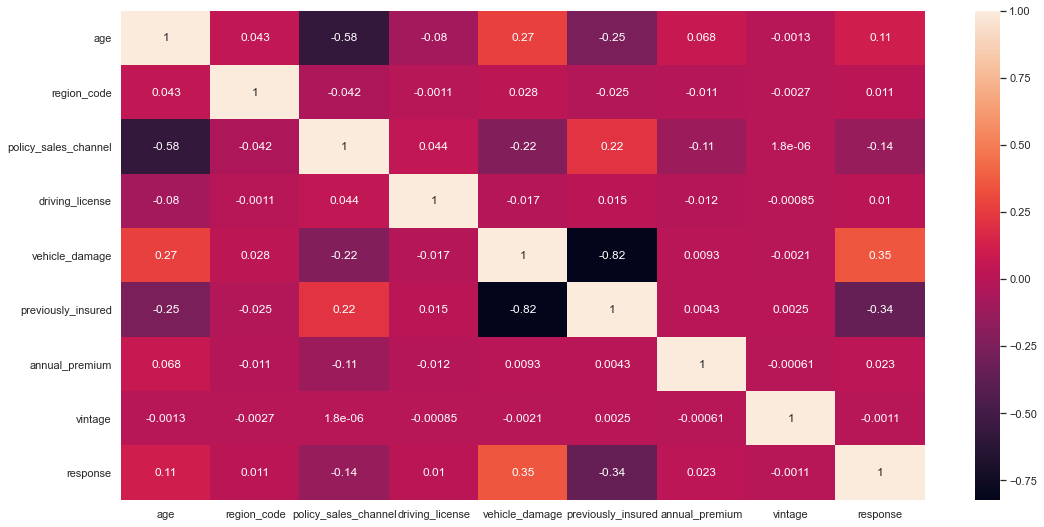

In [46]:
correlation = num_atributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [47]:
a = df4.select_dtypes(include='object')
a.head()

,gender,vehicle_age,risk
0,Male,< 1 Year,high_risk
1,Female,1-2 Year,low_risk
2,Female,< 1 Year,medium_risk
3,Female,< 1 Year,medium_risk
4,Male,1-2 Year,medium_risk


In [52]:
# calculate cramer v
a1 = cramer_v(a['vehicle_age'], a['gender'])
a2 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a3 = cramer_v(a['vehicle_age'], a['risk'])

a4 = cramer_v(a['gender'], a['gender'])
a5 = cramer_v(a['gender'], a['vehicle_age'])
a6 = cramer_v(a['gender'], a['risk'])

a7 = cramer_v(a['risk'], a['risk'])
a8 = cramer_v(a['risk'], a['gender'])
a9 = cramer_v(a['risk'], a['vehicle_age'])

d = pd.DataFrame({'vehicle_age': [a1,a2,a3], 'gender': [a4,a5,a6], 'risk': [a7,a8,a9]})
d.set_index(d.columns)

,vehicle_age,gender,risk
vehicle_age,0.167,1.000,1.000
gender,1.000,0.167,0.059
risk,0.346,0.059,0.346


<AxesSubplot:>

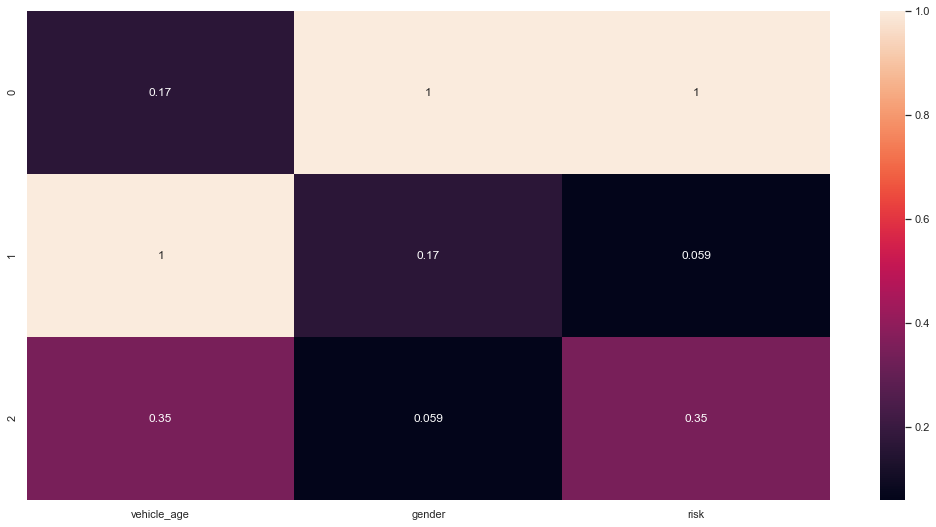

In [53]:
sns.heatmap(d, annot=True)

# 5.0 Data preparation

In [307]:
df5 = df4.copy()

## 5.1 Split dataframe into training and validation dataset

In [308]:
from sklearn.model_selection import train_test_split

In [309]:
X = df5.drop(columns='response', axis=1)
y = df5['response'].copy()

In [310]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [311]:
X_performance = X_valid.copy()

## 5.2 Rescaling

In [316]:
from sklearn.preprocessing import MinMaxScaler

In [317]:
mm = MinMaxScaler()

X_train['age'] = mm.fit_transform(X_train[['age']].values)
X_valid['age'] = mm.fit_transform(X_valid[['age']].values)

X_train['region_code'] = mm.fit_transform(X_train[['region_code']].values)
X_valid['region_code'] = mm.fit_transform(X_valid[['region_code']].values)

X_train['policy_sales_channel'] = mm.fit_transform(X_train[['policy_sales_channel']].values)
X_valid['policy_sales_channel'] = mm.fit_transform(X_valid[['policy_sales_channel']].values)

X_train['annual_premium'] = mm.fit_transform(X_train[['annual_premium']].values)
X_valid['annual_premium'] = mm.fit_transform(X_valid[['annual_premium']].values)

X_train['vintage'] = mm.fit_transform(X_train[['vintage']].values)
X_valid['vintage'] = mm.fit_transform(X_valid[['vintage']].values)

## 5.3 Encoding

In [318]:
X_train['gender'] = X_train['gender'].map({'Female':0,'Male':1})
X_valid['gender'] = X_valid['gender'].map({'Female':0,'Male':1})

X_train['driving_license'] = X_train['driving_license'].map({'no':0,'yes':1})
X_valid['driving_license'] = X_valid['driving_license'].map({'no':0,'yes':1})

X_train['vehicle_damage'] = X_train['vehicle_damage'].map({'No':0,'Yes':1})
X_valid['vehicle_damage'] = X_valid['vehicle_damage'].map({'No':0,'Yes':1})

X_train['previously_insured'] = X_train['previously_insured'].map({'no':0,'yes':1})
X_valid['previously_insured'] = X_valid['previously_insured'].map({'no':0,'yes':1})

y_train = y_train.map({'no':0,'yes':1})
y_valid = y_valid.map({'no':0,'yes':1})

# 6.0 Feature Selection

In [319]:
df6 = df5.copy()

# 7.0 Machine Learning Modeling

In [320]:
df7 = df6.copy()

## 7.1 Baseline Model

In [321]:
from sklearn.dummy import DummyClassifier

In [322]:
from sklearn import metrics as m

In [323]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
pred = dummy.predict(X_valid)
pred_proba_dummy = dummy.predict_proba(X_valid)

### Model Performance

In [324]:
df_performance_dummy = X_performance.copy()

In [325]:
df_performance_dummy['response'] = y_valid.copy()

# propensity score
df_performance_dummy['score'] = pred_proba_dummy[:, 1].tolist()

# compute metrics at K
df_metrics_dummy = metrics_at_k(df_performance_dummy, 'dummy', k=20000)

In [326]:
dummy_results = ml_metrics('dummy', y_valid, pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000


### Cumulative Gain Curve

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

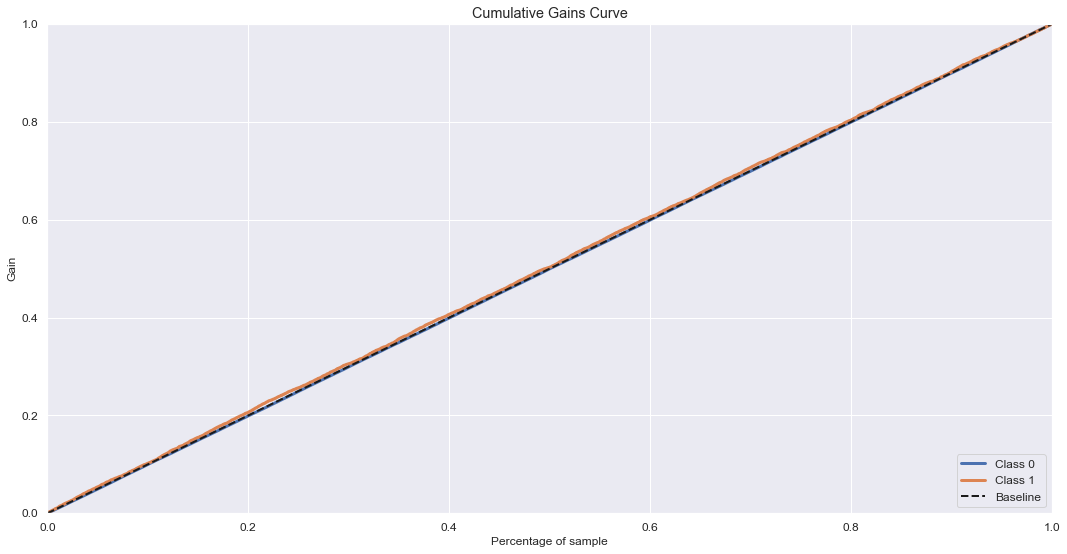

In [327]:
sckp.metrics.plot_cumulative_gain(y_valid, pred_proba_dummy)

## 7.2 Logistic Regression

In [328]:
from sklearn.linear_model import LogisticRegression

In [329]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_valid)
pred_proba_lr = lr.predict_proba(X_valid)

### Model Performance

In [330]:
df_performance_lr = X_performance.copy()

In [331]:
df_performance_lr['response'] = y_valid.copy()
df_performance_lr['score'] = pred_proba_lr[:, 1].tolist()
df_metrics_lr = metrics_at_k(df_performance_lr, 'Logistic Regression', k=20000)

In [332]:
logistic_regression_results = ml_metrics('Logistic Regression', y_valid, pred)
logistic_regression_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.500,0.000,0.000,0.000,0.000


### Cumulative Gain Curve

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

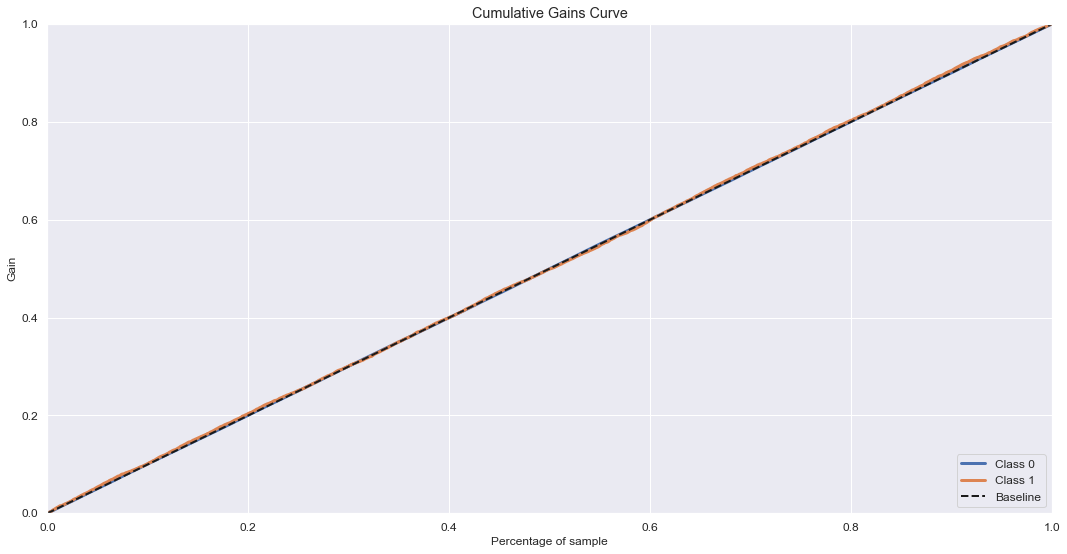

In [333]:
sckp.metrics.plot_cumulative_gain(y_valid, pred_proba_lr)

## 7.3 KNN

In [334]:
from sklearn.neighbors import KNeighborsClassifier

In [335]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_valid)
pred_proba_knn = knn.predict_proba(X_valid)

### Model Performance

In [336]:
df_performance_knn = X_performance.copy()

In [337]:
df_performance_knn['response'] = y_valid.copy()

df_performance_knn['score'] = pred_proba_knn[:, 1].tolist()
df_metrics_knn = metrics_at_k(df_performance_knn, 'KNN',  k=20000)

In [338]:
knn_results = ml_metrics('KNN', y_valid, pred)
knn_results 

,Balanced Accuracy,Precision,Recall,F1,Kappa
KNN,0.500,0.150,0.020,0.030,0.010


### Cumulative Gain Curve

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

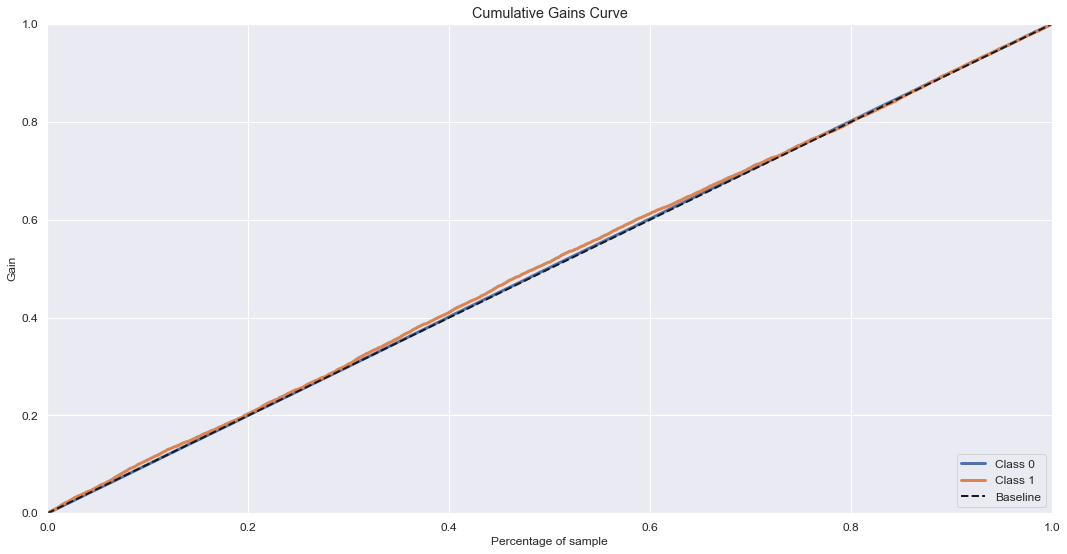

In [339]:
sckp.metrics.plot_cumulative_gain(y_valid, pred_proba_knn)

## 7.5 LightGBM

In [340]:
import lightgbm 

In [341]:
lgb = lightgbm.LGBMClassifier(objective='binary', class_weight='balanced')
lgb.fit(X_train, y_train)
pred = lgb.predict(X_valid)
pred_proba_lgb = lgb.predict_proba(X_valid)

### Model Performance

In [342]:
df_performance_lgb = X_performance.copy()

In [343]:
df_performance_lgb['response'] = y_valid.copy()

df_performance_lgb['score'] = pred_proba_lgb[:, 1].tolist()
df_metrics_lgb = metrics_at_k(df_performance_lgb, 'LGBM', k=20000)

In [344]:
lgbm_results = ml_metrics('LGBM', y_valid, pred)
lgbm_results 

,Balanced Accuracy,Precision,Recall,F1,Kappa
LGBM,0.800,0.280,0.930,0.430,0.300


### Cumulative Gain Curve

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

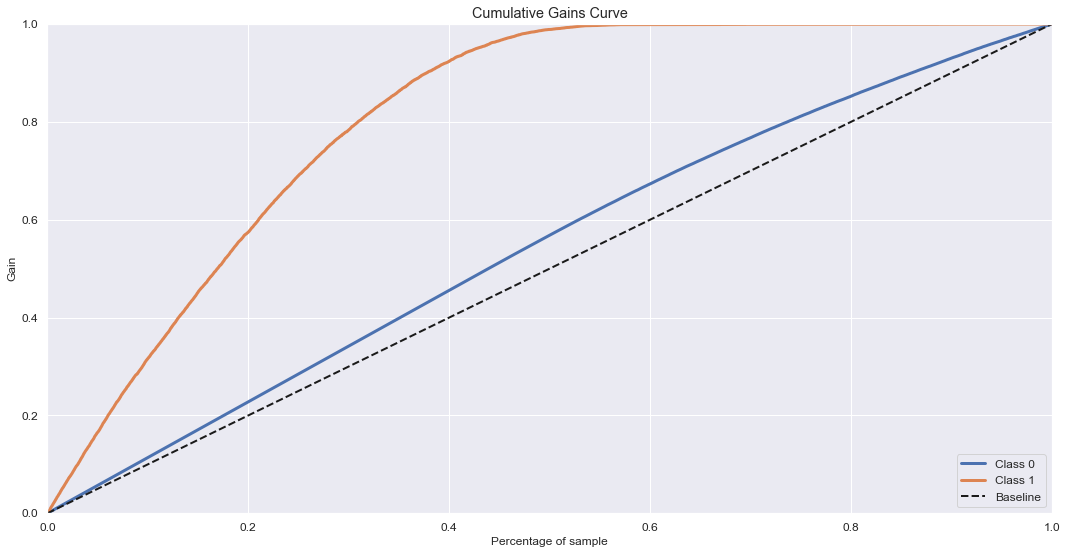

In [345]:
sckp.metrics.plot_cumulative_gain(y_valid, pred_proba_lgb)

## 7.6 Random Forest

In [346]:
from sklearn.ensemble import RandomForestClassifier

In [347]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1)

In [348]:
rf.fit(X_train, y_train)
pred = rf.predict(X_valid)
pred_proba_rf = rf.predict_proba(X_valid)

### Model Performance

In [349]:
df_performance_rf = X_performance.copy()

df_performance_rf['response'] = y_valid.copy()

df_performance_rf['score'] = pred_proba_rf[:, 1].tolist()

df_metrics_rf = metrics_at_k(df_performance_rf, 'Random Forest', k=20000)

In [350]:
rf_results = ml_metrics('Random Forest', y_valid, pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.520,0.370,0.040,0.080,0.050


### Cumulative Gain Curve

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

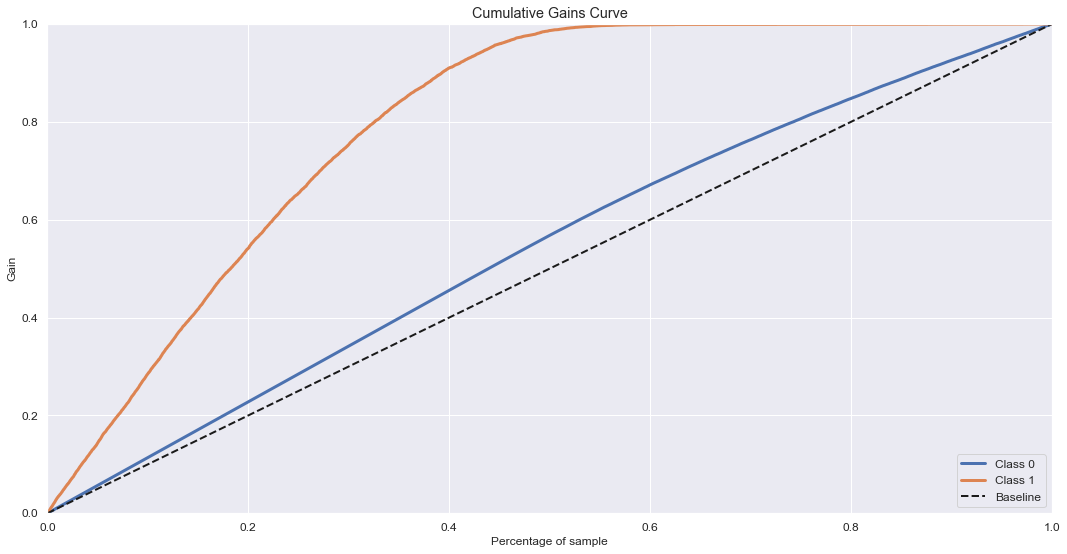

In [351]:
sckp.metrics.plot_cumulative_gain(y_valid, pred_proba_rf)

## 7.7 XGBoost

In [352]:
from xgboost import XGBClassifier

In [353]:
xgb = XGBClassifier(objective='binary:logistic', verbosity=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_valid)
pred_proba_xgb = xgb.predict_proba(X_valid)

### Model Performance

In [354]:
df_performance_xgb = X_performance.copy()

df_performance_xgb['response'] = y_valid.copy()

df_performance_xgb['score'] = pred_proba_xgb[:, 1].tolist()
df_metrics_xgb = metrics_at_k(df_performance_xgb, 'XGBoost', k=20000)

In [355]:
xgb_results = ml_metrics('XGBoost', y_valid, pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.510,0.420,0.020,0.030,0.020


### Cumulative Gain Curve

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

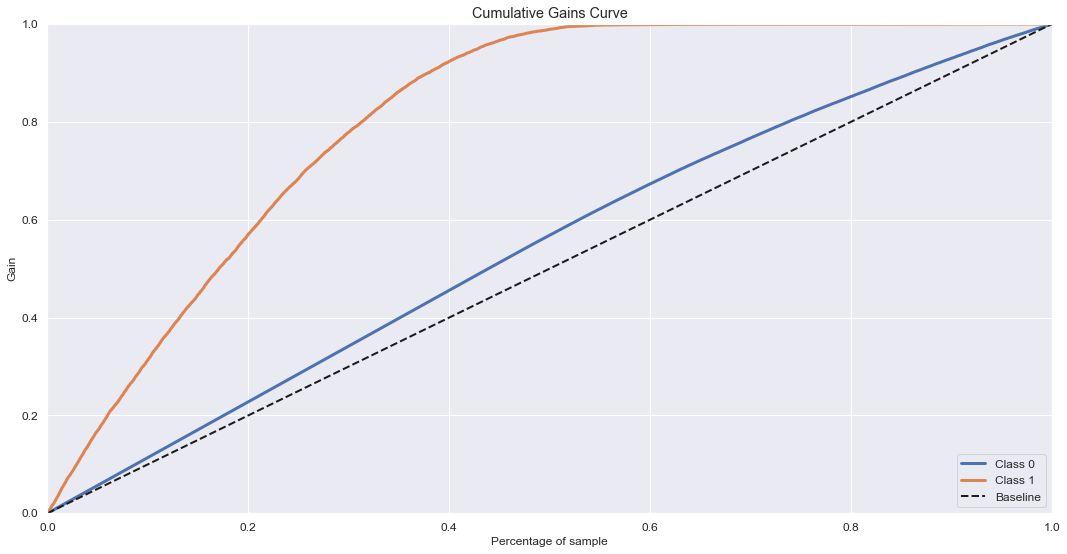

In [356]:
sckp.metrics.plot_cumulative_gain(y_valid, pred_proba_xgb)

## 7.8 Results

### Results at K

In [357]:
df_results_at_k = pd.concat([df_metrics_dummy, df_metrics_lr, df_metrics_knn, df_metrics_lgb, df_metrics_rf, df_metrics_xgb])
df_results_at_k.style.highlight_max(color='lightgreen', axis=0)

,Precision_at_k,Recall_at_k
dummy,0.424829,0.909548
Logistic REegression,0.078396,0.167844
KNN,0.208540,0.446478
LGBM,0.311834,0.667630
Random Forest,0.356082,0.762364
XGBoost,0.345483,0.739670


### Results Regular Metrics

In [358]:
df_results = pd.concat([dummy_results, logistic_regression_results, knn_results,lgbm_results, rf_results, xgb_results])
df_results.style.highlight_max(color='lightgreen', axis=0)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500000,0.000000,0.000000,0.000000,0.000000
Logistic Regression,0.500000,0.000000,0.000000,0.000000,0.000000
KNN,0.500000,0.150000,0.020000,0.030000,0.010000
LGBM,0.800000,0.280000,0.930000,0.430000,0.300000
Random Forest,0.520000,0.370000,0.040000,0.080000,0.050000
XGBoost,0.510000,0.420000,0.020000,0.030000,0.020000


# 8.0 Hyperparameter Fine Tuning

# 9.0 Conclusions

# 10.0 Deploy